In [6]:
import os
import sys
import numpy as np
import random
import argparse
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from astropy.wcs.docstrings import imgpix_matrix
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable
from argparse import Namespace
from tqdm.auto import tqdm

## 参数配置

In [8]:
args = Namespace(
        ckptpath='./checkpoints.ckpt',
        dataset_dir='../food11/training',
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        seed=6666,
)

# 设置全局的随机种子
def all_seed(seed=6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')
all_seed(args.seed)

Set env random_seed = 6666


In [9]:
# Model definition
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        def building_block(indim, outdim):
            return [
                nn.Conv2d(indim, outdim, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(outdim),
                nn.ReLU(),
            ]

        def stack_blocks(indim, outdim, block_num):
            layer_list = building_block(indim, outdim)
            for i in range(block_num - 1):
                layer_list += building_block(indim, outdim)
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            return layer_list

        cnn_list = []
        cnn_list += stack_blocks(3, 64, 1)
        cnn_list += stack_blocks(64, 128, 1)
        cnn_list += stack_blocks(128, 256, 1)
        cnn_list += stack_blocks(256, 512, 1)
        cnn_list += stack_blocks(512, 512, 1)
        self.cnn = nn.Sequential(*cnn_list)
        dnn_list = [
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11),
        ]
        self.fc = nn.Sequential(*dnn_list)

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [10]:
model = Classifier().to(args.device)
checkpoint = torch.load(args.ckptpath,weights_only=False)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [11]:
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        self.paths = paths
        self.labels = labels
        # 数据增强操作（随机水平翻转、随机旋转等）。
        tr_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evl_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = tr_transform if mode == 'train' else evl_transform

    def __len__(self):
        return len(self.paths)

    # 返回图片张量和对应标签。
    def __getitem__(self, idx):
        X = Image.open(self.paths[idx])
        X = self.transform(X)
        Y = self.labels[idx]
        return X, Y

    # 将图片堆叠成一个四维张量 (batch_size, channels, height, width)。
    # 标签转换为张量后返回。
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

def get_paths_labels(path):
    def my_key(name):
        return int(name.replace(".jpg", "").split("_")[1]) + 1000000 * int(name.split("_")[0])

    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split("_")[0]))
    return imgpaths, labels

train_paths, train_labels = get_paths_labels(args.dataset_dir)
# print(train_paths,train_labels)
train_set = FoodDataset(train_paths, train_labels, mode='evl')

### 样本查看

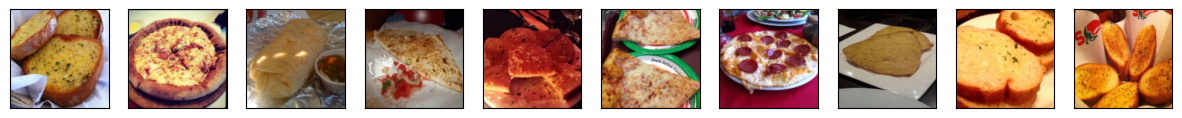

In [13]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
# 遍历所有子图 axs，并移除它们的 x 轴和 y 轴刻度（增强图片显示效果）。
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs]
for i, img in enumerate(images): 
    # 改变张量维度顺序，从 (C, H, W) 变为 (H, W, C)（高度、宽度、通道），符合 imshow 的格式要求。
    axs[i].imshow(img.cpu().permute(1, 2, 0))
plt.show()

## &#x2728; Lime (Q1~4) 
[Lime](https://github.com/marcotcr/lime) 是一个关于解释机器学习分类器(`classifier`)正在做什么的包。我们可以先用它来观察模型。  
也可以通过阅读[Local Interpretable Model-Agnostic Explanations (LIME): An Introduction](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)来了解lime的大致原理

这里我们通过：
- `lime_image.LimeImageExplainer().explain_instance` 对我们的CNN模型进行解释  
- `explaination.get_image_and_mask` 将关注用于分类的特征可视化

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

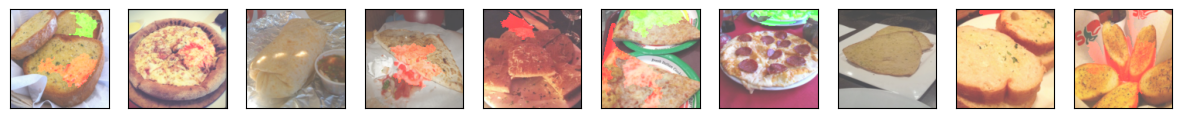

In [32]:
def predict(ipt):
    # ipt: numpy array, (batches, height, width, channels)
    model.eval()
    input = torch.FloatTensor(ipt).permute(0, 3, 1, 2)
    # pytorch tensor, (batches, channels, height, width)
    output = model(input.cuda())
    return output.data.cpu().numpy()
    
# 图像分割函数，用于将图像分割为超像素（superpixels）。LIME 使用超像素来生成解释。
def segmentation(input):
    # 借助skimage.segmentation中的分割图像方法slic，将图像分割成200块 compactness=1：控制超像素的紧凑性。
    # sigma=1：高斯平滑的标准差。
    return slic(input, n_segments=100, compactness=1, sigma=1, start_label=1)

fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs]
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    x = image.astype(np.double)
    # numpy array for lime
    explainer = lime_image.LimeImageExplainer() # LIME 的图像解释器，用于生成图像分类模型的局部解释。
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance
    # 从解释中提取可视化的图像和遮罩。
    # lime_img用颜色标记解释区域的图像。mask二值化的掩码图，指示哪些区域参与了解释。
    lime_img, mask = explaination.get_image_and_mask(
            label=label.item(), # 指定要解释的类别（标签）。
            positive_only=False, # 是否只显示对该类别有正面影响的区域。
            hide_rest=False, # 是否隐藏不相关区域。
            num_features=11,  # 进行解释的最大特征数-图片mask颜色不一样
            min_weight=0.05 # 最小权重，决定显示的区域对预测的最小贡献。
        )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    axs[idx].imshow(lime_img, alpha=0.7)
    
plt.show()
plt.close()

## &#x2728; 显著性Map`Saliency Map` (Q5~9)

热图突出显示输入图像中在分类任务中贡献最大的像素。
参考: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

我们在模型中放入一张图像，然后计算损失。因此，损失与下列三个因素相关：
*   图像：image
*   模型（参数）：model parameters
*   标签：label

一般来说，我们改变模型参数以适应“图像”和“标签”。当向后传播时，我们计算**损失对模型参数**的偏微分值，然后进行梯度下降。

现在，我们再看一眼。当我们改变图像的像素值时，**损失对图像**的偏微分值显示了损失的变化。我们可以说这意味着像素的重要性。我们可以将其可视化，以证明图像的哪一部分对模型的判断贡献最大。

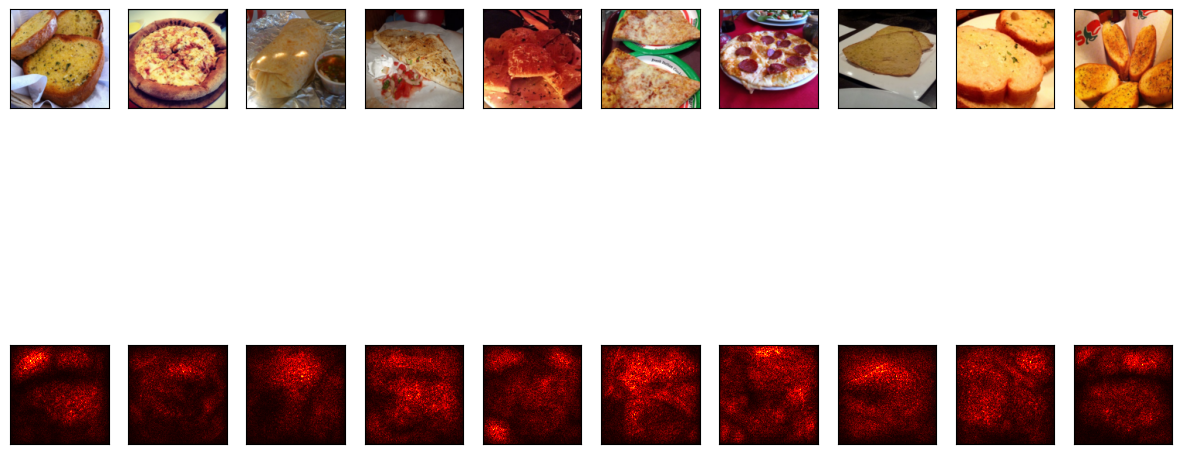

In [18]:
# 梯度显著性图 (Saliency Map) 的计算和可视化，理解模型对某些输入的关注区域。
#  对单张图片进行归一化，使其像素值范围映射到 [0, 1]。
# 原因：梯度值的范围可能非常大或很小，归一化可以让显著性图在可视化时更具对比效果。
def normalize(image):
    # maxMinScale
    return (image - image.min()) / (image.max() - image.min())
    # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()

    # 允许x进行微分计算
    x.requires_grad_()

    y_pred = model(x)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda())
    loss.backward()

    # saliencies = x.grad.abs().detach().cpu() 
    # 拿取梯度最大值 (batch, channels, height, width) -> (batch, height, width) 
    saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

    # 对每个图片单独进行归一化： 因为它们的梯度可能在比例上有所不同
    saliencies = torch.stack([normalize(item) for item in saliencies])
    return saliencies

# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        if row==0: # 原来的图片 - image
            axs[row][column].imshow(img.permute(1, 2, 0).numpy())
          # permute是什么：
          # 在pytorch中, 图像存储维度为 (channels, height, width)
          # 在matplotlib中, 图像存储维度为 (height, width, channels)
          # permute用以改变图像的 dim
          # 比如：img.permute(1, 2, 0) 表示,
          # - 原来的第1维度->变成第0维度  
          # - 原来的第2维度->变成第1维度 
          # - 原来的第0维度->变成第2维度 
        else: # channel中梯度最大的灰度图片- saliencies
            axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
    
plt.show()
plt.close()

## &#x2728; Smooth Grad (Q10~13)
Smooth grad 的方法是，在图片中随机的加入`noise`, 然后得到不同的`heetmap`，把这些`heetmap`进行平均，这样能得到一个比较抗`noisy gradient`。


参考文献: https://arxiv.org/pdf/1706.03825.pdf

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

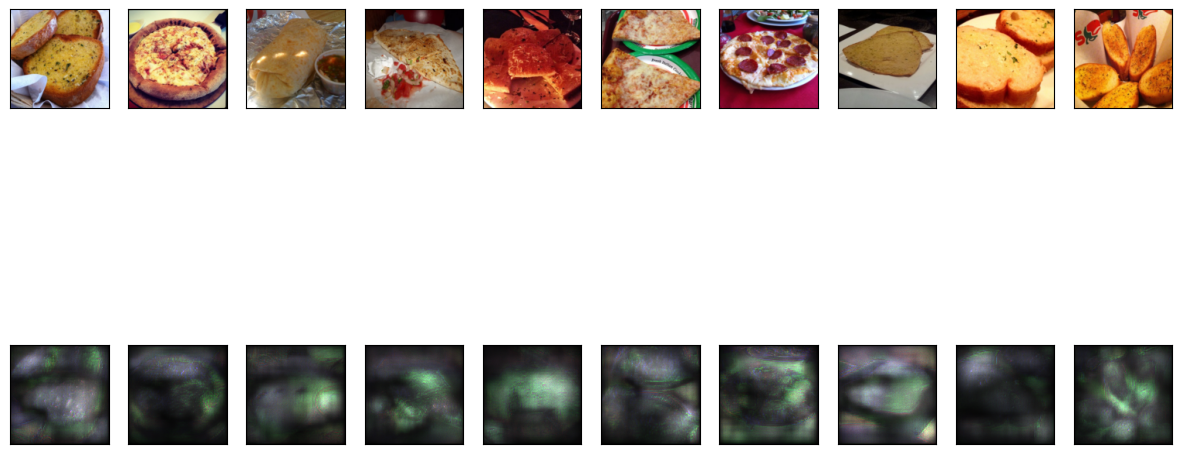

In [20]:
# SmoothGrad 算法，通过在输入上添加噪声多次计算梯度，
# 然后对这些梯度取平均值，来减少显著性图中的噪声，使模型关注区域更加稳定和清晰。

def normalize(image):
    # maxMinScale
    return (image - image.min()) / (image.max() - image.min())

# param_sigma_multiplier: 控制随机噪声强度的参数。
# 平滑后的显著性图，形状与输入图像相同。
def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
    model.eval()
    #x = x.cuda().unsqueeze(0)

    mean = 0
    # sigma 根据输入图像的像素值范围动态调整，确保噪声强度与图像数据的尺度一致。
    sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
    smooth = np.zeros(x.cuda().unsqueeze(0).size())
    for i in tqdm(range(epoch), leave=False):
        # 增加噪声
        noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
        x_mod = (x+noise).unsqueeze(0).cuda()
        x_mod.requires_grad_()
        # ：添加噪声后的图像
        
        y_pred = model(x_mod)
        loss_func = torch.nn.CrossEntropyLoss()
        loss = loss_func(y_pred, y.cuda().unsqueeze(0))
        loss.backward()

        # 和 saliency map 差不多求梯度绝对值， 但是不进行最大值
        smooth += x_mod.grad.abs().detach().cpu().data.numpy()
    # 归一化梯度值，增强显著性图的对比度，使得关注区域更明显。
    smooth = normalize(smooth / epoch) # 不要忘记进行归一化 平均化所有梯度显著性图，减小噪声的影响。
    # smooth = smooth / epoch # try this line to answer the question
    # (batch, channels, height, width) -> (batch, channels, height, width) 
    return smooth

# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
    smooth.append(smooth_grad(i, l, model, 500, 0.4))
smooth = np.stack(smooth)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for row, target in enumerate([images, smooth]):
    for column, img in enumerate(target):
        axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)))

## &#x2728; Filter Explanation (Q14~17)

这里我们想知道每个`filter`到底认出了什么。我们会做两件事：
- Filter activation: 挑出几张图片，看看图片中哪些位置 activate 这个 filter
- Filter visualization: 找出怎样的 image 可以最大程度的 activate 这个 filter

实际上比较困难的地方是，通常我们是直接把 image 丢进 model, 进行正常的`forward`，比如：
```python
loss = model(image)
loss.backward()
```
我们要怎么得到中间某层 CNN 的 output ?
1. 可以直接修改`model definition`, 让 `forward` 同时也`return activation map`, 单这样的写法就麻烦了，会涉及大量的代码改动
2. 直接用 pytorch 提供了方便的方法: **hook**

In [43]:
# filter_explanation 方法是为了可视化卷积神经网络（CNN）中某层（cnnid）特定滤波器（filterid）的激活映射
# 以及优化输入图像以最大化该滤波器激活的可视化。

def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

# 用于存储在钩子（hook）中捕获的某层的激活输出。
# 后续会通过钩子函数捕获指定层的激活图。
layer_activations = None 

def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
    """
    x: 输入的图片
    cnnid: 卷积层的索引，即指定卷积层。
    filterid: 需要可视化的卷积层中滤波器的索引。
    iteration: 用于优化输入图像的迭代次数。
    lr: 优化输入图像时的学习率。
    filter_activations：
    输入图像通过指定卷积层后，该滤波器的激活映射。
    用于观察滤波器在特定输入图像上的表现。
    filter_visualizations：
    通过优化生成的输入图像，该图像最大化了指定滤波器的激活。
    用于理解滤波器偏好的特征。
    """
    model.eval()

    def hook(model, input, output):
        global layer_activations
        layer_activations = output
    
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # 当模型`forwards` 通过 layer[cnnid], 它会调用hook方法
    # hook方法保存 layer[cnnid] 的输出 
    # register_forward_hook 方法允许你在指定层的前向传播过程中捕获输入和输出。
    # 前向传播结束后，我们会得到 loss 和 layer activation

    # Filter activation: x 通过 filter 生成 activation map
    model(x.cuda())

    # 根据函数参数给定的filterid，获取特定filterid的激活映射`activation map`
    # 我们只需要绘制它，这样我们就可以从图中分离出来，并保存为cpu张量
    filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
    
    # Filter visualization: 找到最能激活 filter的图像
    x = x.cuda()
    x.requires_grad_()
    # input image gradient
    optimizer = Adam([x], lr=lr)
    # 使用优化器修改输入图像以放大过滤器激活（filter activation）
    for _ in range(iteration):
        optimizer.zero_grad()
        model(x)
        
        objective = -layer_activations[:, filterid, :, :].sum()
        # 我们想要最大化`filter activation`的总和, 所以我们加一个负号
        
        objective.backward()
        # 计算`filter activation`对输入图像的偏微分值
        optimizer.step()
        # 修改输入图像以最大化`filter activation`
    filter_visualizations = x.detach().cpu().squeeze()

    # 不要忘记移除 hook
    hook_handle.remove()
    # hook将在模型注册后存在，所以你必须在使用后将其移除。如果你想使用它，只需注册一个新的hook
    return filter_activations, filter_visualizations

In [45]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


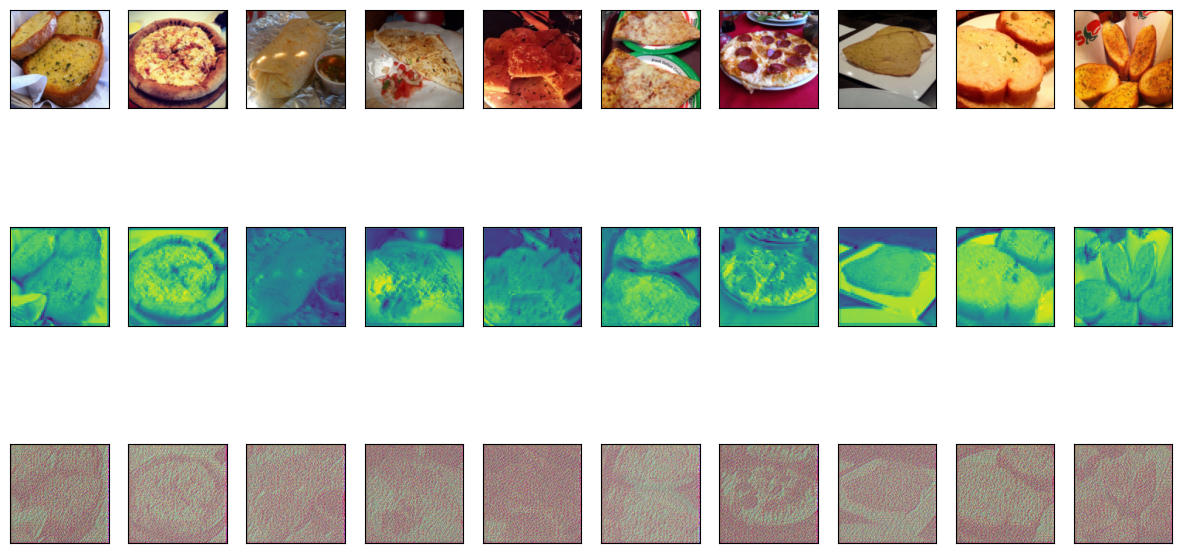

In [52]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=4, filterid=0, iteration=100, lr=0.1)

fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()

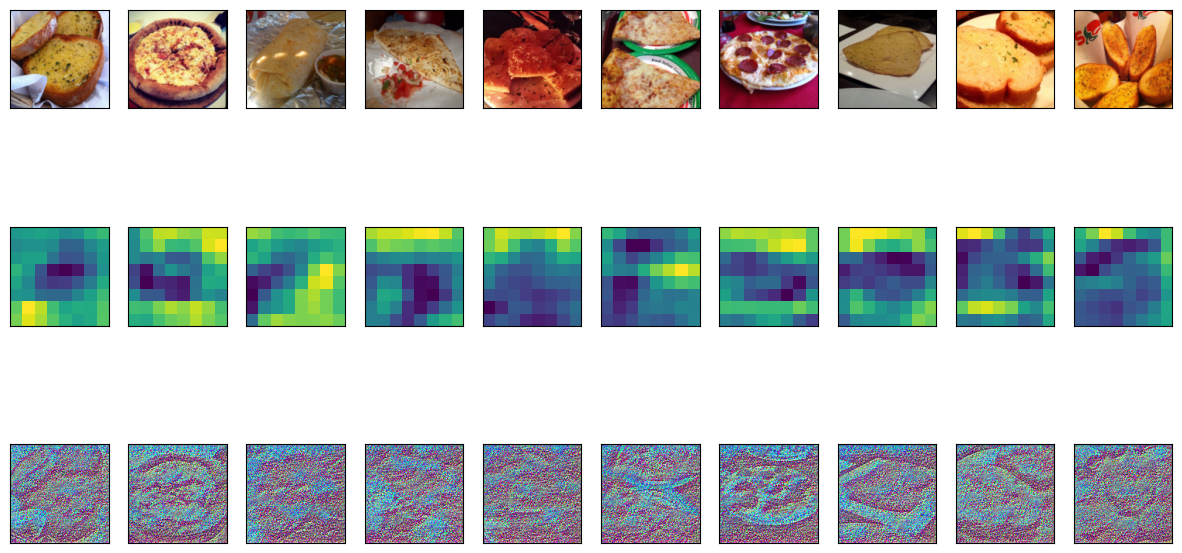

In [53]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=16, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
    axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


## &#x2728; 综合梯度(`Integrated Gradients`) (Q18~20)
🧵 IntegratedGradients 类使用了以下关键步骤：
1.生成缩放输入路径：
使用 generate_images_on_linear_path 方法创建一系列从基线到目标输入之间的过渡输入。

2.反向传播梯度：
使用 generate_gradients 方法计算输入图像与目标类别之间的梯度。

3.集成梯度计算：
使用 generate_integrated_gradients 方法将所有路径输入的梯度平均，从而获得对输入图像与目标类别之间贡献度的集成解释。

In [57]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # 将模型设置成 evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # 生成缩放的xbar图像 
        # steps指定路径上的步骤数。
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # 生成输入图像对目标类别的梯度
        input_image.requires_grad=True
        model_output = self.model(input_image)
        self.model.zero_grad()
        # 反向探测目标
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # 反向传播
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # 转成numpy (1,3,128,128) -> (3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # 生成缩放的xbar图像
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # 初始化由零组成的图像
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # 从xbar图像生成梯度
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # 从xbar图像中添加重新缩放的梯度
            integrated_grads = integrated_grads + single_integrated_grad/steps

        # (1,3,128,128) -> (3,128,128)
        return integrated_grads[0]


def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

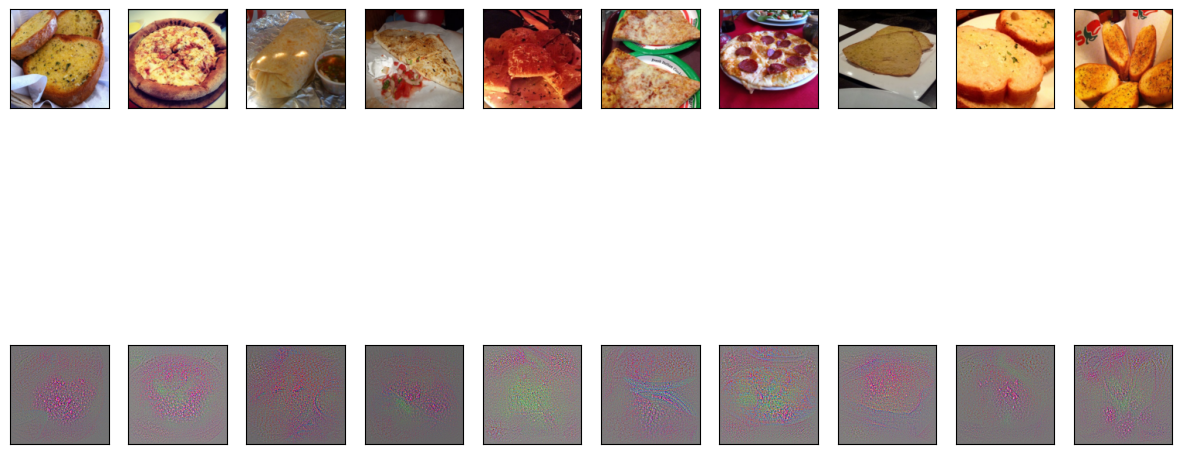

In [59]:
images, labels = train_set.getbatch(img_indices)
images = images.cuda()

IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
    img = img.unsqueeze(0)
    integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 10))

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
_ = [(i.set_xticks([]), i.set_yticks([])) for i in axs.flatten()]
for i, img in enumerate(images):
    axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
    axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()